Data from Salces-Castellano et al 2021

[Flightlessness in insects enhances diversification and determines assemblage structure across whole communities](https://royalsocietypublishing.org/doi/full/10.1098/rspb.2020.2646)

    The age of the oldest subaerially-erupted lavas on each island decreases from east to west along the island chain: Lanzarote-Fuerteventura (20.2 Ma), Gran Canaria (14.6 Ma), Tenerife (11.9 Ma), La Gomera (9.4 Ma), La Palma (1.7 Ma) and El Hierro (1.1 Ma).
* See also Carracedo & Troll 2016 - [The Geology of the Canary Islands](https://www.google.com/books/edition/The_Geology_of_the_Canary_Islands/DztUCwAAQBAJ?hl=en&gbpv=1&pg=PP1&printsec=frontcover)

In [128]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import shutil

from collections import Counter
from itertools import combinations
from scipy.stats import entropy

import sys
sys.path.append('/home/isaac/proj/IMEMEBA-BCI')
import BCI

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read metadata

In [22]:
metadata = pd.read_csv("README.txt", sep="\t", index_col=None)
metadata

,Label,LMDH,Family,Wing_status,Sampling,Island,Locality,Lat,Lon
0,1,LMDH278,Silphidae,Wingless,Mixed,Tenerife,CTE,28.5620,-16.1714
1,2,LMDH278,Silphidae,Wingless,Mixed,Tenerife,CTE,28.5620,-16.1714
2,3,LMDH278,Silphidae,Wingless,Mixed,Tenerife,CTE,28.5620,-16.1714
3,4,LMDH278,Silphidae,Wingless,Mixed,Tenerife,CTE,28.5620,-16.1714
4,5,LMDH278,Silphidae,Wingless,Mixed,Tenerife,AGU,28.5334,-16.2698
...,...,...,...,...,...,...,...,...,...
3990,7758,LMDH055,Curculionidae,Wingless,Mixed,La Palma,LOM,28.8038,-17.8203
3991,7760,LMDH065,Curculionidae,Wingless,Mixed,La Palma,LOM,28.8038,-17.8203
3992,7761,LMDH086,Latridiidae,Winged,Mixed,La Palma,LOM,28.8038,-17.8203
3993,7762,LMDH062,Cerambycidae,Winged,Vegetation,La Palma,LOM,28.8038,-17.8203


## Map sites to islands

In [115]:
group = metadata.groupby(["Island"])
sites_per_island = {island[0]: list(set(group["Locality"])) for island, group in group}
sites_per_island["Tenerife-Teno"] = ['PAS', 'COC']
sites_per_island["Tenerife"].remove('PAS')
sites_per_island["Tenerife"].remove('COC')
sites_per_island

{'El Hierro': ['FAY', 'MEN'],
 'La Gomera': ['APA', 'CED', 'MEV', 'ACE', 'FUE', 'EHA', 'REV'],
 'La Palma': ['CUB', 'NIQ', 'LOM', 'CUM'],
 'Tenerife': ['IJU',
  'CHI',
  'CTE',
  'AGU',
  'NIE',
  'TAG',
  'ANE',
  'PIJ',
  'ZAP',
  'MOQ'],
 'Tenerife-Teno': ['PAS', 'COC']}

## Map zotus to site codes

In [116]:
zotus_per_site = {}
gb = metadata.groupby(['Locality'])
for site, samps in gb:
    # select only the zotu columns. Cast zotu Labels as strings (to avoid auto-detecting as int64)
    zotus_per_site[site[0]] = samps["Label"].values.astype(str)

for k, v in zotus_per_site.items():
    print(k, "\t", len(v))

ACE 	 206
AGU 	 179
ANE 	 153
APA 	 77
CED 	 182
CHI 	 202
COC 	 197
CTE 	 198
CUB 	 108
CUM 	 158
EHA 	 258
FAY 	 87
FUE 	 176
IJU 	 171
LOM 	 144
MEN 	 94
MEV 	 172
MOQ 	 116
NIE 	 130
NIQ 	 137
PAS 	 174
PIJ 	 173
REV 	 162
TAG 	 202
ZAP 	 139


## Make a dict mapping OTU names to sequences

In [117]:
seq_data = open("Sequences.fasta").read().split()

zotus = [x[1:] for x in seq_data[::2]]
# Strip trailing gaps (not sure why they are there)
# vsearch doesn't like gaps
fastas = [x.replace("-", "N") for x in seq_data[1::2]]

#seq_df = {x:y for x,y in zip(zotus, fastas)}
seq_df = pd.Series(fastas, index=zotus)
seq_df

1       NNNNNNNACACCCTGAAGTATATATTCTAATTCTCCCAGGATTTGG...
3       NNNNNNNACACCCTGAAGTATATATTCTAATTCTCCCAGGATTTGG...
4       NNNNNNNACACCCTGAAGTATATATTCTAATTCTCCCAGGATTTGG...
5       NNNNNNNACACCCTGAAGTATATATTCTAATTCTCCCAGGATTTGG...
6       NNNNNNNACACCCTGAAGTATATATTCTAATTCTCCCAGGATTTGG...
                              ...                        
4817    NNNNNNNNNACCCAGAAGTTTATATTTTAATTTTACCAGGATTTGG...
4823    NNNNNNNNNACCCAGAAGTTTATATTTTAATTTTACCAGGATTTGG...
4824    NNNNNNNNNACCCAGAAGTTTATATTTTAATTTTACCAGGATTTGG...
4825    NNNNNNNNNACCCAGAAGTTTATATTTTAATTTTACCAGGATTTGG...
4826    NNNNNNNNNACCCAGAAGTTTATATTTTAATTTTACCAGGATTTGG...
Length: 3995, dtype: object

In [ ]:
## Make a new fasta file for all the sequences w/in a site

In [40]:
if not os.path.exists("site_fastas"):
    os.mkdir("site_fastas")

for site, zotus in zotus_per_site.items():
    fasta_data = seq_df.loc[zotus]
    # Check fasta files should be this length
    print(site, len(fasta_data)*2)
    with open(f"site_fastas/{site}.fasta", 'w') as outfile:
        for k, v in fasta_data.items():
            outfile.write(f">{k}\n{v}\n")

ACE 412
AGU 358
ANE 306
APA 154
CED 364
CHI 404
COC 394
CTE 396
CUB 216
CUM 316
EHA 516
FAY 174
FUE 352
IJU 342
LOM 288
MEN 188
MEV 344
MOQ 232
NIE 260
NIQ 274
PAS 348
PIJ 346
REV 324
TAG 404
ZAP 278


## Run BCIs

In [42]:
fastas = sorted(glob.glob("site_fastas/*.fasta"))
bcis = {}
for fasta in fastas:
    site = fasta.split("/")[1].split(".")[0]
    print(site)
    bcis[site] = BCI.BCI(data=fasta, verbose=True)
    bcis[site]._min_clust_threshold = 70
    bcis[site].run()

ACE
[130, 72, 61, 61, 60, 59, 58, 57, 57, 56, 55, 51, 50, 44, 41, 37, 32, 27, 22, 18, 15, 12, 6, 5, 5, 3, 2, 1, 1, 1]
AGU
[122, 65, 53, 49, 49, 49, 48, 48, 47, 46, 42, 41, 39, 37, 35, 31, 28, 24, 20, 17, 10, 9, 4, 2, 2, 1, 1, 1, 1, 1]
ANE
[113, 65, 53, 51, 51, 51, 50, 50, 50, 48, 44, 44, 42, 41, 40, 37, 36, 29, 27, 21, 17, 11, 5, 2, 2, 1, 1, 1, 1, 1]
APA
[66, 34, 30, 29, 29, 29, 29, 29, 29, 29, 28, 27, 27, 25, 24, 24, 23, 21, 17, 15, 13, 9, 6, 5, 4, 2, 2, 1, 1, 1]
CED
[128, 66, 58, 55, 54, 54, 54, 53, 53, 53, 52, 50, 50, 43, 39, 37, 33, 29, 25, 19, 15, 9, 8, 6, 5, 3, 2, 1, 1, 1]
CHI
[145, 79, 71, 67, 67, 64, 63, 63, 63, 59, 52, 45, 44, 41, 40, 39, 34, 28, 22, 18, 14, 8, 4, 2, 1, 1, 1, 1, 1, 1]
COC
[141, 86, 76, 74, 73, 72, 72, 71, 70, 70, 66, 61, 56, 52, 50, 43, 39, 35, 22, 18, 12, 7, 5, 3, 2, 1, 1, 1, 1, 1]
CTE
[135, 75, 64, 60, 60, 59, 59, 59, 57, 54, 50, 47, 42, 40, 39, 37, 30, 26, 21, 16, 14, 9, 4, 2, 1, 1, 1, 1, 1, 1]
CUB
[70, 46, 43, 41, 40, 40, 40, 40, 40, 40, 39, 37, 35, 32, 29

## Plot BCIs

In [118]:
cmaps = {x:y for x,y in zip(sites_per_island, ["Greys", "Purples", "Greens", "Blues", "Reds"])}


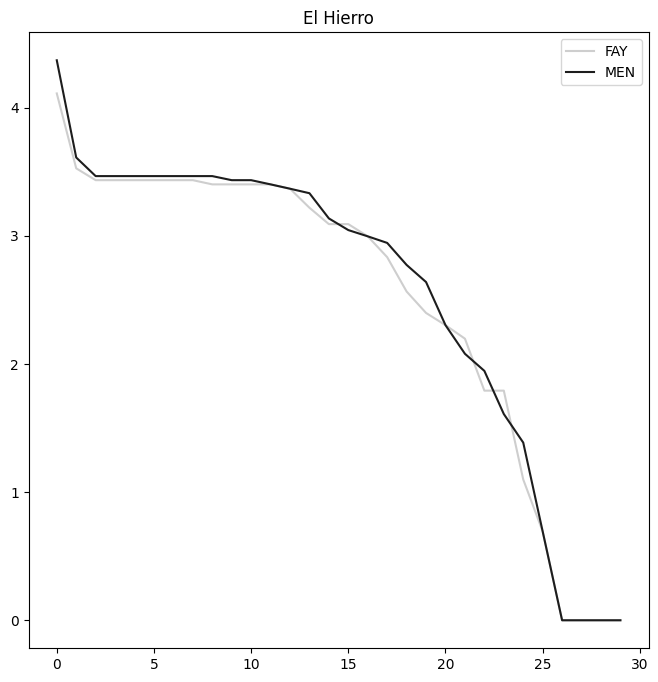

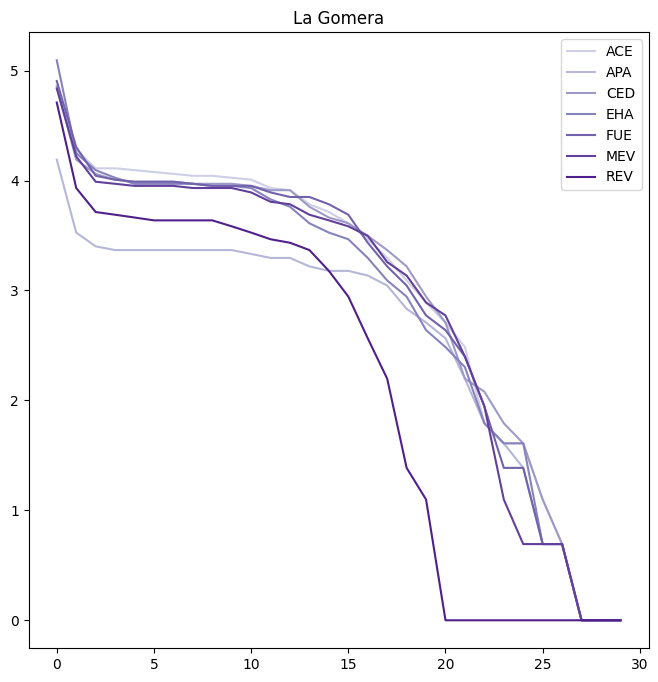

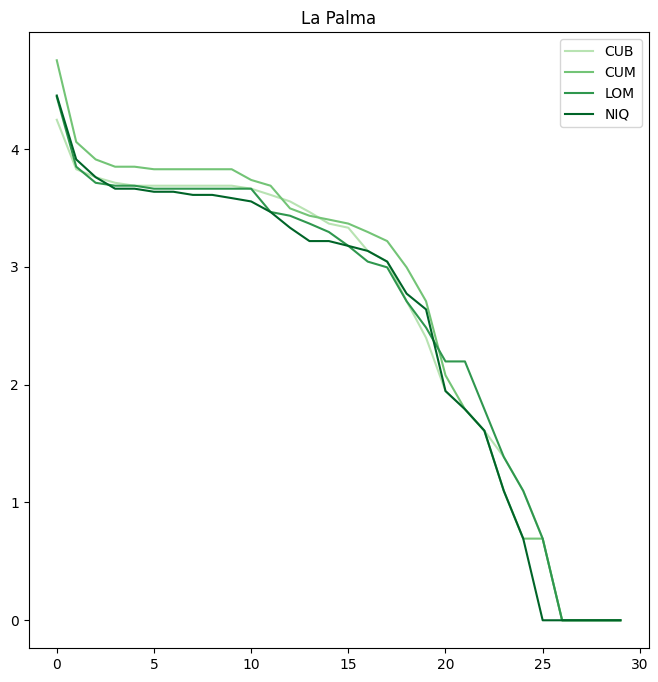

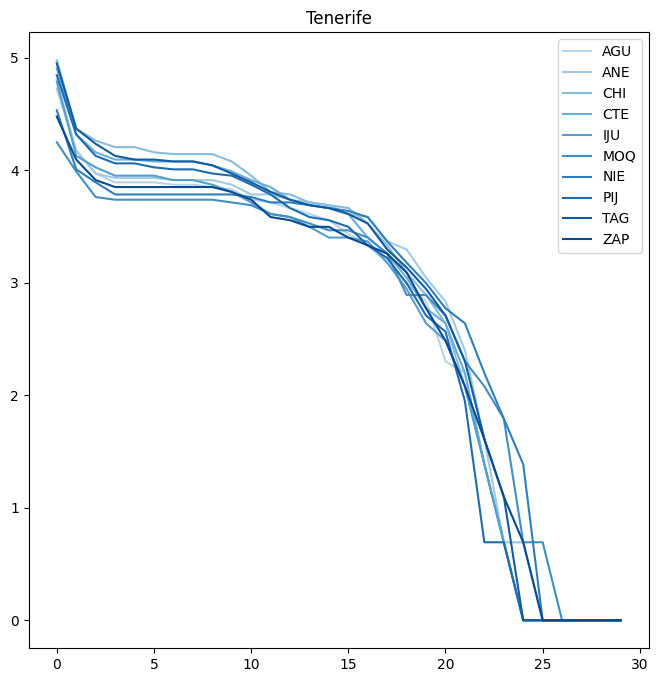

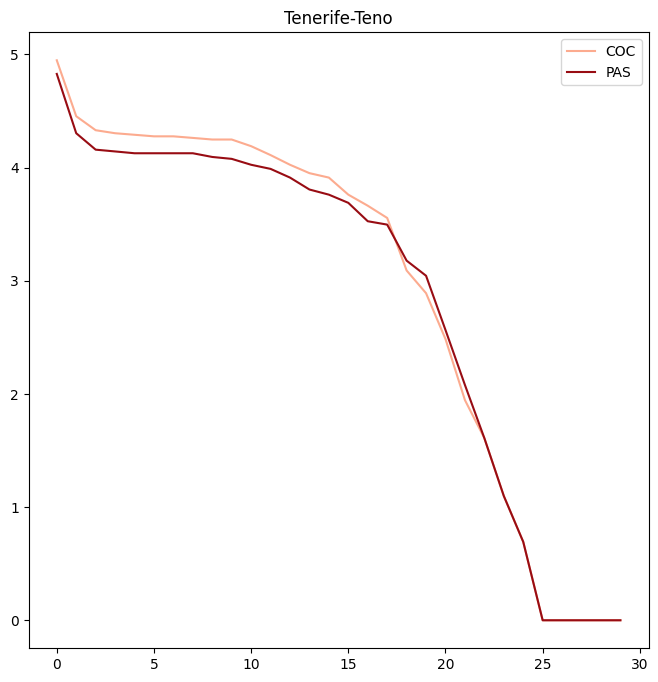

In [119]:
for island in sites_per_island.keys():
    fig, ax = BCI.plot_multi([bci for bci in bcis.values() if bci.samp in sites_per_island[island]],
                   cmap=cmaps[island], log=True, normalize=False)
    ax.set_title(island)

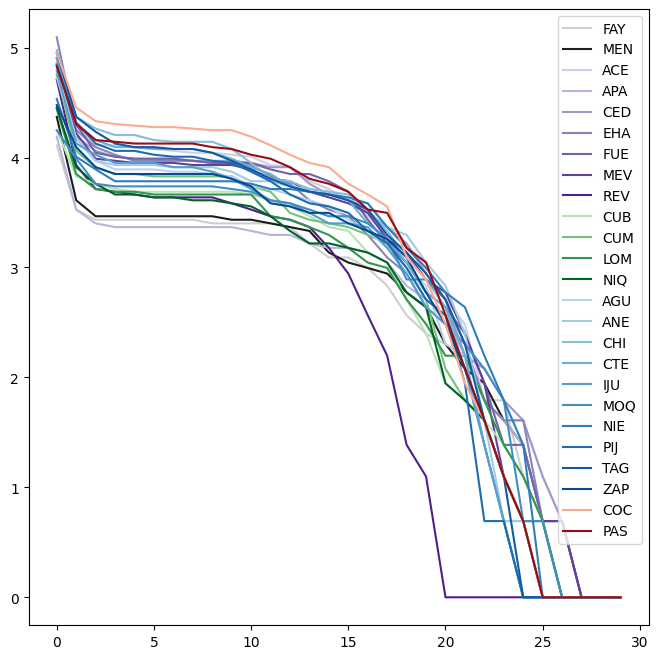

In [120]:
fig, ax = plt.subplots(figsize=(8,8))
for island in sites_per_island.keys():
    fig, ax = BCI.plot_multi([bci for bci in bcis.values() if bci.samp in sites_per_island[island]],
                   ax=ax, cmap=cmaps[island], log=True, normalize=False)


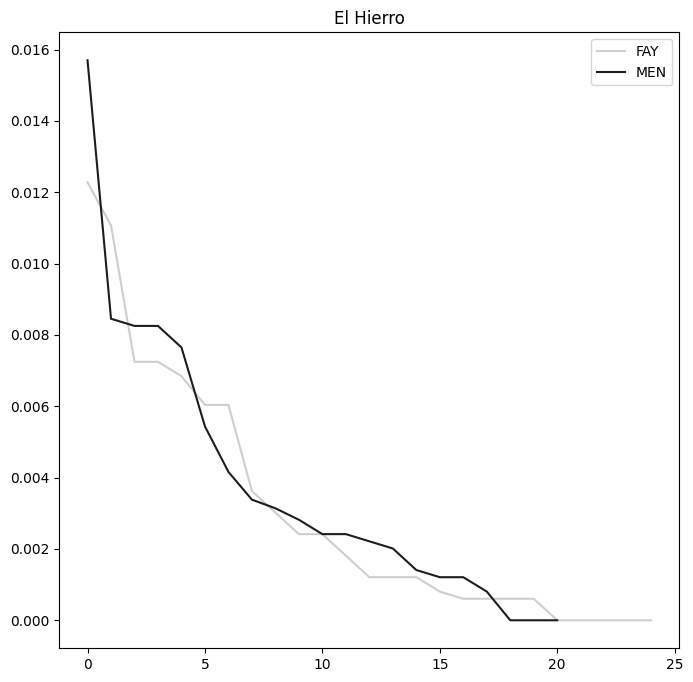

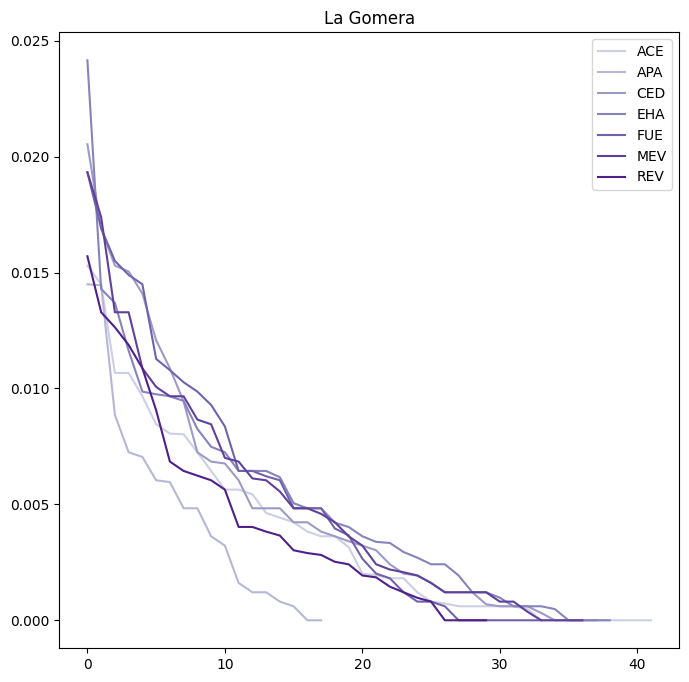

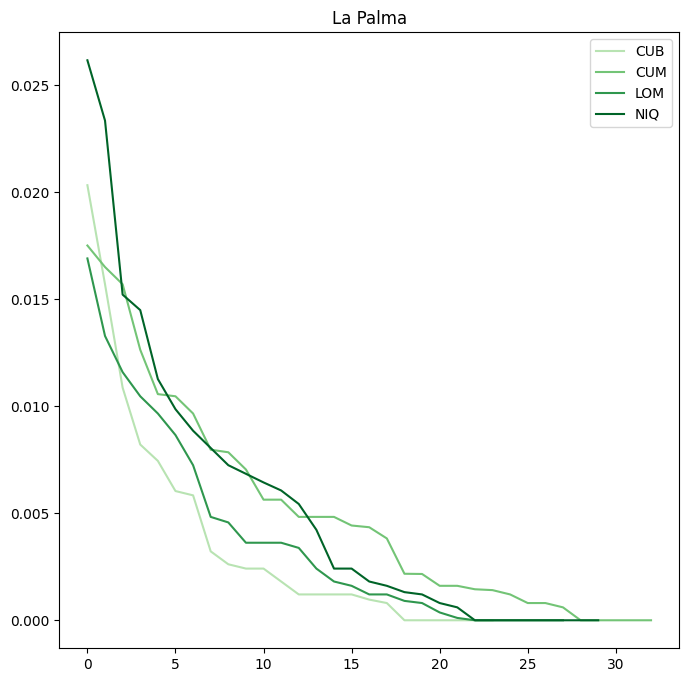

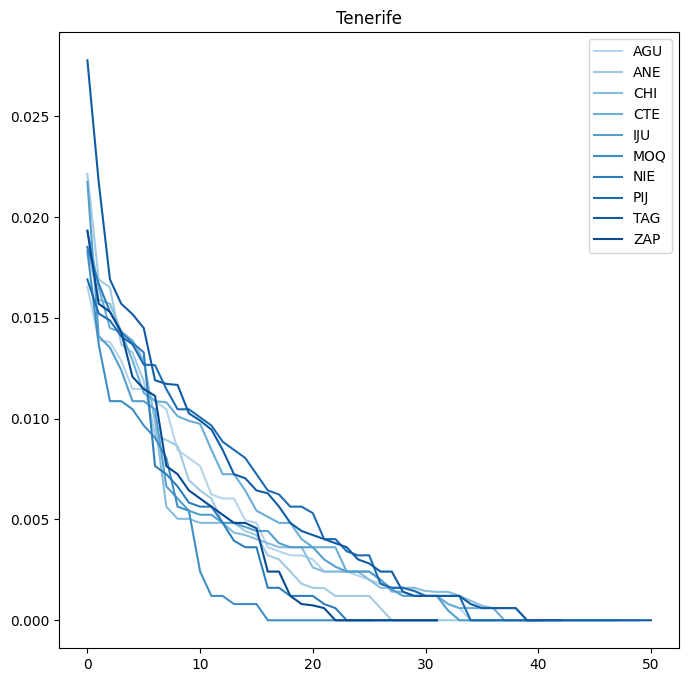

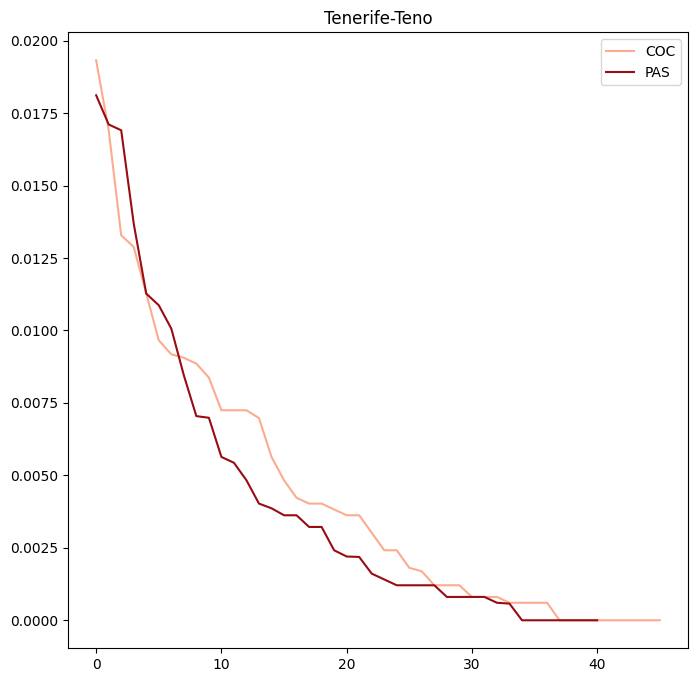

In [121]:
for island in sites_per_island.keys():
    fig, ax = BCI.plot_multi([bci for bci in bcis.values() if bci.samp in sites_per_island[island]],
                   cmap=cmaps[island], log=True, normalize=False, plot_pis=True)
    ax.set_title(island)

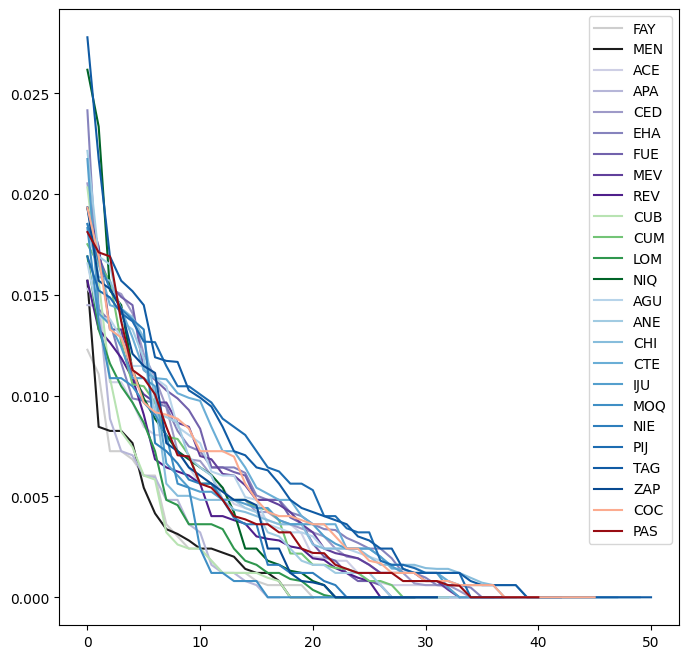

In [122]:
fig, ax = plt.subplots(figsize=(8,8))
for island in sites_per_island.keys():
    fig, ax = BCI.plot_multi([bci for bci in bcis.values() if bci.samp in sites_per_island[island]],
                   ax=ax, cmap=cmaps[island], log=True, normalize=False, plot_pis=True)


In [ ]:
## Choose 2 random samples per island so the pattern is less dominated by tenerife

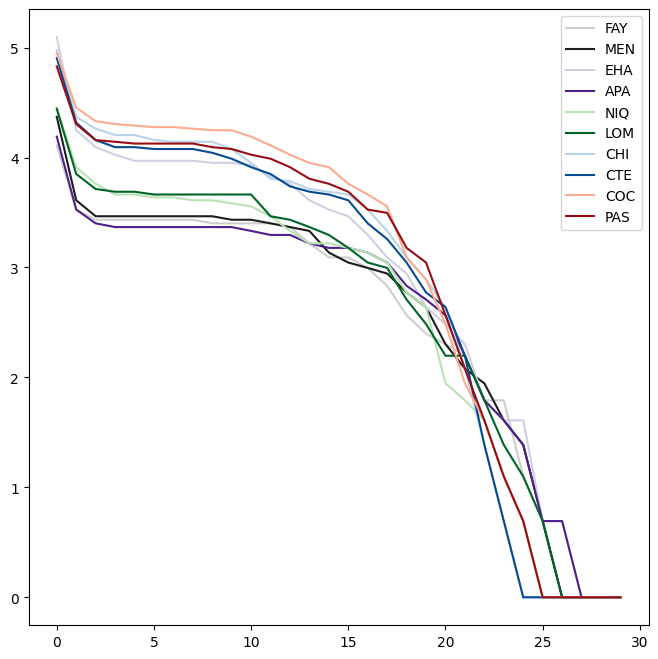

In [126]:
fig, ax = plt.subplots(figsize=(8,8))
for island in sites_per_island.keys():
    fig, ax = BCI.plot_multi(np.random.choice([bci for bci in bcis.values() if bci.samp in sites_per_island[island]], 2, replace=False),
                   ax=ax, cmap=cmaps[island], log=True, normalize=False)


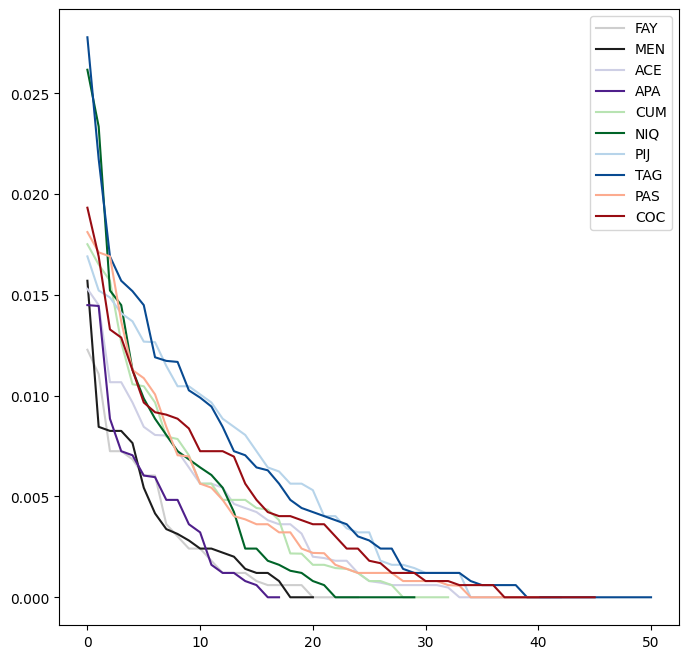

In [127]:
fig, ax = plt.subplots(figsize=(8,8))
for island in sites_per_island.keys():
    fig, ax = BCI.plot_multi(np.random.choice([bci for bci in bcis.values() if bci.samp in sites_per_island[island]], 2, replace=False),
                   ax=ax, cmap=cmaps[island], log=True, normalize=False, plot_pis=True)


## Lump all sites together per island

In [147]:
if os.path.exists("island_fastas"):
    shutil.rmtree("island_fastas")
if not os.path.exists("island_fastas"):
    os.mkdir("island_fastas")

for island, sites in sites_per_island.items():
    island = island.replace(" ", "_")
    fasta_out = f"island_fastas/{island}.fasta"
    # Standardize sampling to 2 random sites per island
    for site in np.random.choice(sites, 2, replace=False):
        zotus = zotus_per_site[site]
        fasta_data = seq_df.loc[zotus]
        with open(fasta_out, 'a') as outfile:
            for k, v in fasta_data.items():
                outfile.write(f">{k}\n{v}\n")

In [148]:
island_fastas = sorted(glob.glob("island_fastas/*.fasta"))
island_bcis = {}
for fasta in island_fastas:
    island = fasta.split("/")[1].split(".")[0]
    print(island)
    island_bcis[island] = BCI.BCI(data=fasta, verbose=True)
    island_bcis[island]._min_clust_threshold = 70
    island_bcis[island].run()

El_Hierro
[129, 53, 44, 44, 44, 44, 44, 44, 43, 42, 42, 41, 40, 37, 30, 27, 26, 22, 17, 14, 10, 10, 7, 6, 3, 2, 1, 1, 1, 1]
La_Gomera
[224, 87, 71, 68, 66, 65, 65, 64, 64, 62, 59, 56, 53, 48, 41, 31, 23, 13, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
La_Palma
[149, 84, 71, 65, 64, 63, 63, 62, 62, 59, 57, 53, 48, 41, 41, 40, 34, 30, 22, 17, 11, 8, 5, 5, 3, 2, 1, 1, 1, 1]
Tenerife-Teno
[237, 116, 97, 93, 92, 91, 89, 89, 87, 85, 81, 75, 68, 62, 58, 53, 46, 43, 30, 25, 17, 9, 5, 3, 2, 1, 1, 1, 1, 1]
Tenerife
[249, 118, 91, 81, 77, 77, 76, 76, 73, 70, 64, 60, 56, 52, 49, 43, 38, 30, 26, 21, 16, 12, 5, 2, 2, 1, 1, 1, 1, 1]


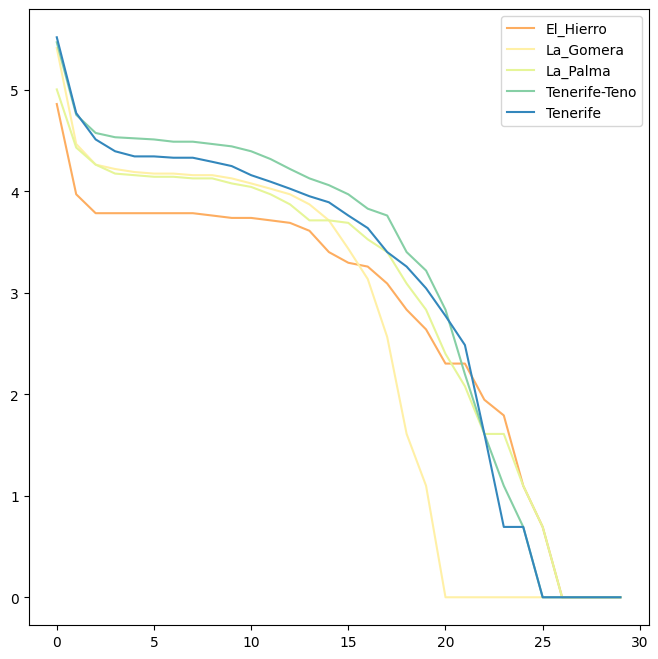

In [149]:
fig, ax = BCI.plot_multi([bci for bci in island_bcis.values()],
               log=True, normalize=False)


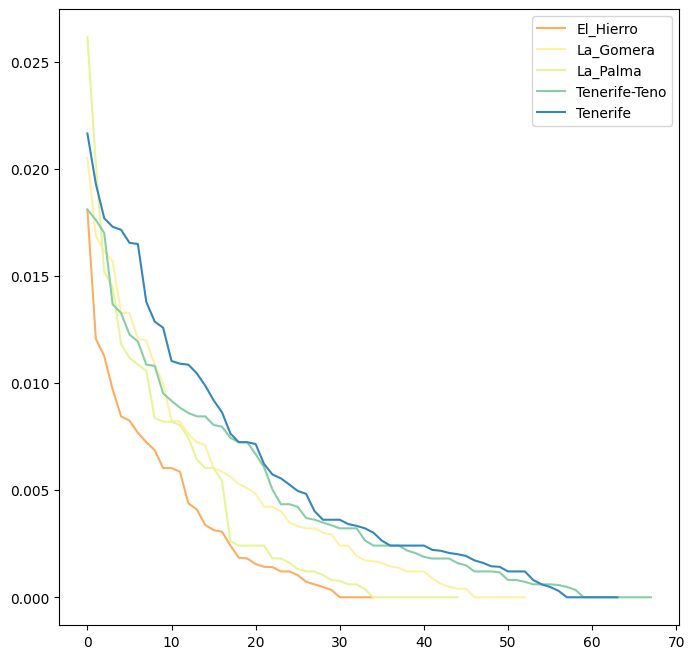

In [150]:
fig, ax = BCI.plot_multi([bci for bci in island_bcis.values()],
               log=True, normalize=False, plot_pis=True)